# GWL - Map Score ELO Model Notebook

## Pipeline Summary  
The basic procedures contained within the notebook

import spreadsheet -> preprocess matches (columns in toydata) ->  
create elo class -> add players for teams-> init team dicts -> bymatch: expectation, gameOver, update dicts/rating ->  
massage final results into output format -> save output -> websitey stuff

## Imports  
All of the packages that will be used in this notebook

In [5]:
#imports
import openpyxl
import pandas as pd
import requests
import json
import math
import random
import dataframe_image as dfi
import matplotlib.pyplot as plt
from io import BytesIO
from operator import itemgetter
pd.set_option("display.precision", 0)

## Import Spreadsheet data as a Pandas DataFrame

In [2]:
# Read in toy data spreadsheet tabs as separate dataframes in a list, season_data
spreadsheetId = "1pYdi5HpVSsOUekqMLw8em5YsfqLW9u_2sMY6kh5Clv8" # Please set your Spreadsheet ID for the current GWL week ######################################################
url = "https://docs.google.com/spreadsheets/export?exportFormat=xlsx&id=" + spreadsheetId
res = requests.get(url)
data = BytesIO(res.content)
xlsx = openpyxl.load_workbook(filename=data)
season_data = []
for name in xlsx.sheetnames:
    new_df = pd.read_excel(data, sheet_name=name)
    new_df.name = name
    season_data.append(new_df)

# Need to remove some rows in the Match Records, filter via rows where matches are played
matches = season_data[0]
matches = matches[matches['Played?'] == True]
season_data[0] = matches

## Define the simple Elo model classes and functions 

In [77]:
# Define ELO model
k = 24 # ELO update scaler
Rm = 3200 # default elo initialization
delta = 500 # scaler on rel(p(win|A,B), A-B) in elo calc's exponential (Q)

class Team:
    def __init__(self, name, Rm=3200):
        self.currentRating = Rm # Current estimate elo rating
        self.opponentHist = [] # sequence of opponents (weekly)
        self.ratingHist = [] # sequence of rating estimates (weekly)
        self.currentRanking = 11 # the team's current ranking among all teams (1-10 in GWL); 11 ~ unranked
        self.rankingHist = [] # sequence of team's standing (weekly)
        
class Elo:
    def __init__(self,Rm = 3200, k=24, g=1, delta=500):
        self.ratingDict = {} # dictionary of all teams and their current ratings; redundant/will be removed. currently accessed by power_rankings()
        self.teamsDict = {} # dictionary of all team objects and their attributes. this will be used for the json output
        self.k = k # k-factor for scaling max change in rating for a match
        self.g = g # g-factor, another modifier to the rating change; will be converted to a margin of victory at a later point.
        self.rankings = {} #  dictionary of the current power rankings; written-to by power_rankings()

    def addPlayer(self,name, Rm = 3200):
        self.ratingDict[name] = Rm # update code by deleting this and subsuming into teams dict
        self.teamsDict[name] = Team(name, Rm)

    def gameOver(self, winner, loser):
        # take single game, chop up number of maps & winner of each
        # combine all updates at once
        #   expectation =  expected score | number of maps & team elos
        #   diff = total map wins (+.5 for draws) - expectation
        result = self.expectResult(self.ratingDict[winner], self.ratingDict[loser]) # compute the expected result
        
        # redundancy
        self.ratingDict[winner] = self.ratingDict[winner] + (self.k*self.g)*(1 - result)  # update elo rating based on error
        self.ratingDict[loser] 	= self.ratingDict[loser] + (self.k*self.g)*(0 - (1 -result))
        
        self.teamsDict[winner].currentRating =  self.teamsDict[winner].currentRating + (self.k*self.g)*(1 - result)
        self.teamsDict[loser].currentRating = self.teamsDict[loser].currentRating + (self.k*self.g)*(0 - (1 -result))  
        
        # update the histories
        self.teamsDict[winner].opponentHist.append(loser) # update winner's opponent
        self.teamsDict[winner].ratingHist.append(self.teamsDict[winner].currentRating) # update winner's rating history
        #self.teamsDict[winner].rankingHist.append(self.teamsDict[winner].currentRanking) #  update winner's power ranking history
        self.teamsDict[loser].opponentHist.append(winner)
        self.teamsDict[loser].ratingHist.append(self.teamsDict[loser].currentRating)
        #self.teamsDict[loser].rankingHist.append(self.teamsDict[loser].currentRanking)

    def seriesOver(self, game):
        # take a full series and compute the updated estiamtes after the sequence of maps
        # each map will be treated like a single binary outcome with winner (score = 1), and  loser (score = 0)
        map_counter = 0
        t1_score = 0
        t2_score = 0
        t1_name = game['Team 1']
        t2_name = game['Team 2']
        for possible_map in range(7):
            if possible_map == 0: # Winner, Winner.2
                winner_col = 'Winner'
            else:
                winner_col =  'Winner.{}'.format(possible_map) # name of column with winner name for the map
            try:
                if (not math.isnan(game[winner_col])) and (game[winner_col] != 'nan') and (game[winner_col] != 'NaN'): # If the map is played, continue
                    winner = game[winner_col] # winner's name
                    if t1_name == winner:  # if team 1 is the winner
                        t1_score += 1 # add  1 to winner's map score
                    elif t2_name == winner:
                        t2_score +=  1
                    elif winner == 'Draw': # draw, may need to edit for error if draw presents differently
                        t1_score += .5
                        t2_score += .5
                    map_counter += 1
            except:
                if (game[winner_col] != 'nan') and (game[winner_col] != 'NaN'): # If the map is played, continue
                    winner = game[winner_col] # winner's name
                    if t1_name == winner:  # if team 1 is the winner
                        t1_score += 1 # add  1 to winner's map score
                    elif t2_name == winner:
                        t2_score +=  1
                    elif winner == 'Draw': # draw, may need to edit for error if draw presents differently
                        t1_score += .5
                        t2_score += .5
                    map_counter += 1
            
        result = self.expectResult(self.ratingDict[t1_name], self.ratingDict[t2_name]) # compute the expected result that t1 is the winner
                
        # redundancy in how ratings are stored due to differing uses for powerranking/other. can be fixed at a later date for parsimony
        
        
        # actual score will be the number of maps taken. this is maybe a faulty assumption, but is the simplest case for now... Implementation of map diffs may be more appropriate
        self.ratingDict[t1_name] = self.ratingDict[t1_name] + (self.k*self.g)*(t1_score - result*map_counter)  # update elo rating based on error (map score - pwin_map * nmaps
        self.ratingDict[t2_name] = self.ratingDict[t2_name] + (self.k*self.g)*(t2_score - (1 -result)*map_counter)

        self.teamsDict[t1_name].currentRating =  self.teamsDict[t1_name].currentRating + (self.k*self.g)*(t1_score - result*map_counter)
        self.teamsDict[t2_name].currentRating = self.teamsDict[t2_name].currentRating + (self.k*self.g)*(t2_score - (1 -result)*map_counter)  

        # update the histories
        self.teamsDict[t1_name].opponentHist.append(t2_name) # update winner's opponent
        self.teamsDict[t1_name].ratingHist.append(self.teamsDict[t1_name].currentRating) # update winner's rating history
        #self.teamsDict[winner].rankingHist.append(self.teamsDict[winner].currentRanking) #  update winner's power ranking history
        self.teamsDict[t2_name].opponentHist.append(t1_name)
        self.teamsDict[t2_name].ratingHist.append(self.teamsDict[t2_name].currentRating)
        #self.teamsDict[loser].rankingHist.append(self.teamsDict[loser].currentRanking)                                                                            

    def expectResult(self, p1, p2):
        exp = (p2-p1)/delta
        return 1/((10.0**(exp))+1)
    
    def update_rankings(self):
        r = 1
        rankings  = []
        for ranking in self.power_rankings():
            team = ranking[1][0]
            self.teamsDict[team].currentRanking = r  #  update  the current ranking
            self.teamsDict[team].rankingHist.append(self.teamsDict[team].currentRanking) # update the ranking history with the new ranking
            rankings.append(r)
            r += 1
        return rankings

    def power_rankings(self):
        self.rankings = sorted(self.ratingDict.items(), key=itemgetter(1), reverse=True)
        power = []
        for i, x in enumerate(self.rankings):
            power.append((i + 1, x))
        return power
    
    def sim_mapscores(self, team1name, team2name, nsims=1000, outfile = None):
        # initialize storage
        outcomes = ['3-0','3-1','3-2','2-3','1-3','0-3'] # we will not simulate draws since that requires scores within the map to simulate, so the elo's WILL miss out on some information.
        outcomesDict = {}
        for outcome in outcomes:
            outcomesDict[outcome] = 0  # initialize dict to keep track of the result of each simulation
        
        # while loop for simulations
        i = 1
        while i < nsims:
            #  simulate a series
            t1score, t2score = self.sim_series(self.teamsDict[team1name].currentRating, self.teamsDict[team2name].currentRating)
            scorestr = '{}-{}'.format(t1score,t2score)
            outcomesDict[scorestr] += 1
            i += 1    
        #update outcomes to be likelihoods instead of raw counts
        for key in outcomesDict:
            outcomesDict[key] = round(outcomesDict[key]/nsims,2)
        # create graph of outcomes
        fig, ax = plt.subplots();
        names = list(outcomesDict.keys())
        values = list(outcomesDict.values())
        bars = ax.barh(names,values);
        ax.set_xlabel('Probability of Outcome');
        ax.set_title('{} vs. {} Map Score Predictions'.format(team1name,team2name));
        ax.bar_label(bars);
        plt.show();
        if outfile == 'default':
            plt.savefig('{}_{}_mappreds.png'.format(team1name[:3],team2name[:3]));
        elif outfile.type() == str:
            plt.savefig(outfile);
        outcomesDict['team1'] = team1name # store which team is which for later decoding if dict is exported for use
        outcomesDict['team2'] = team2name
        return outcomesDict
                    
    def sim_result(self,elo1,elo2):
        rv = random.random() # random variable [0,1)
        p1win = self.expectResult(elo1,elo2)
        if rv <= p1win:
            return 1
        else:
            return 0
    def sim_series(self,elo1,elo2):
        t1score = 0
        t2score = 0
        while (t1score < 3) and (t2score < 3):
            if self.sim_result(elo1,elo2):
                t1score += 1
                elo1 = elo1 + (self.k*self.g)*(1 - self.expectResult(elo1,elo2)) # updating elos after each map for  the simulation
                elo2 = elo2 + (self.k*self.g)*(0 - self.expectResult(elo1,elo2))
            else:
                t2score += 1
                elo1 = elo1 + (self.k*self.g)*(0 - self.expectResult(elo1,elo2))
                elo2 = elo2 + (self.k*self.g)*(1 - self.expectResult(elo1,elo2))
        return t1score, t2score

## Model Implementation/ Testing

In [78]:
# initialize the elo model
GWL = Elo(Rm = 3200, k=100, g=1, delta=1000)

# initialize teams
teams = ['Iceland Imps', 'Ema Skies', 'Arizona O-Teas', 'Troubling Trout', 'Dorado Ducks','Awesome Anglers','Phiji Phrogs','Pokhara Pusheens','Chicago Cats','Welsh Whales']
for team in teams:
    GWL.addPlayer(team)

week = 1
for i, game in matches.iterrows():
    GWL.seriesOver(game) # update ELO's from the series
    if (game['Round #'] > week) or (i == len(matches)-1): # update the power rankings at the end of a week
        GWL.update_rankings()
        week +=1
#vars(GWL.teamsDict['A'])
#GWL.update_rankings()
#GWL.teamsDict['A'].rankingHist

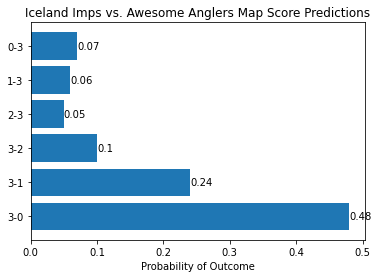

<Figure size 432x288 with 0 Axes>

In [79]:
# Feel free to put in any two teams to test likelihoods! (Just change t1/t2 to the teams you want)
t1= 'Iceland Imps'
t2 = 'Awesome Anglers'
results = GWL.sim_mapscores(t1,t2,nsims = 10000, outfile= 'default')

## Output and save model results

## Visualization

In [142]:
# Next week match  preds table
# Want table with columns for team 1 /2 : ELO, rank, likelihood of victory
nweek_preds =  pd.DataFrame(columns= ['Rank', 'Team', '% Win', '% Win ', 'Team ', 'Rank ']);

# List of teams  for next week in order of Team 1  vs Team 2, Team 3 vs Team 4, etc...
nweek_teams = ['Awesome Anglers','Pokhara Pusheens','Iceland Imps','Chicago Cats','Arizona O-Teas','Dorado Ducks','Ema Skies','Welsh Whales','Troubling Trout','Phiji Phrogs']
# get the ranks for each
nweek_ranks  = []
for team in nweek_teams:
    nweek_ranks.append(GWL.teamsDict[team].currentRanking)
# compute the likelihoods
odds = []
teamnum = 0
for team  in nweek_teams:
    if (teamnum % 2)  == 0: #if even
        odds.append(int(round(100*GWL.expectResult(GWL.teamsDict[team].currentRating,GWL.teamsDict[nweek_teams[teamnum+1]].currentRating))))
        teamnum += 1
    else:
        odds.append(int(round(100*GWL.expectResult(GWL.teamsDict[team].currentRating,GWL.teamsDict[nweek_teams[teamnum-1]].currentRating))))
        teamnum += 1
# fill in the dataframe with the appropriate info from the lists
for mnum in range(int((len(nweek_teams)+1)/2)):
    t1num = mnum*2
    t2num = mnum*2+1
    nweek_preds.loc[mnum,:] = [nweek_ranks[t1num],nweek_teams[t1num],odds[t1num],odds[t2num],nweek_teams[t2num],nweek_ranks[t2num]]
#preds_styled = nweek_preds.style.background_gradient();
preds_styled = nweek_preds.style.hide_index();
dfi.export(preds_styled,"nweek_preds_mapmodel.png");  # uncomment to save table
preds_styled

C:\Users\Rory\AppData\Local\Temp\ipykernel_11568\3294299372.py:27: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  preds_styled = nweek_preds.style.hide_index();
C:\Users\Rory\anaconda3\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


Rank,Team,% Win,% Win,Team,Rank
5,Awesome Anglers,44,56,Pokhara Pusheens,4
1,Iceland Imps,90,10,Chicago Cats,10
9,Arizona O-Teas,17,83,Dorado Ducks,3
2,Ema Skies,80,20,Welsh Whales,7
8,Troubling Trout,38,62,Phiji Phrogs,6


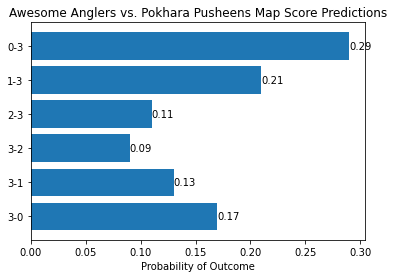

<Figure size 432x288 with 0 Axes>

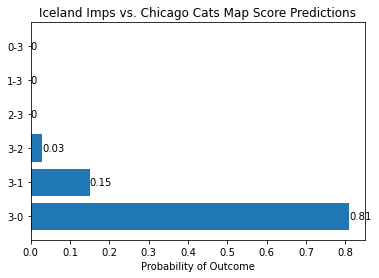

<Figure size 432x288 with 0 Axes>

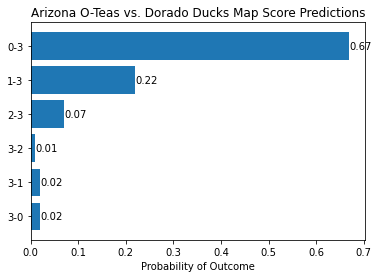

<Figure size 432x288 with 0 Axes>

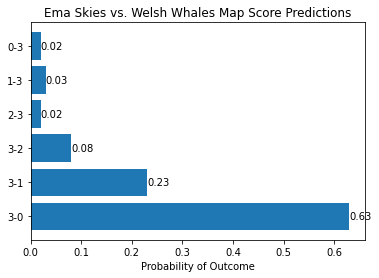

<Figure size 432x288 with 0 Axes>

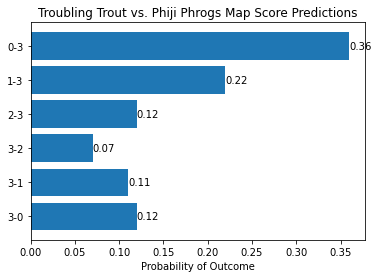

<Figure size 432x288 with 0 Axes>

In [81]:
# Next week likelihoods
nweek_teams = ['Awesome Anglers','Pokhara Pusheens','Iceland Imps','Chicago Cats','Arizona O-Teas','Dorado Ducks','Ema Skies','Welsh Whales','Troubling Trout','Phiji Phrogs']
n_matches = 5
for m in range(n_matches):
    t1 = nweek_teams[m*2]
    t2 = nweek_teams[2*m+1]
    GWL.sim_mapscores(t1,t2,nsims = 10000, outfile= 'default')

##  To Do's: 
- make graphs look better (e.g. minor  offsets, line colors, etc)